In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import regularizers

import keras
from keras.models import Model
from keras.layers import Dropout, Flatten, Input, AveragePooling2D, merge, Activation, ReLU, Lambda
from keras.layers import Conv2D,SeparableConv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate

import tensorflow as tf

In [3]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train,img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


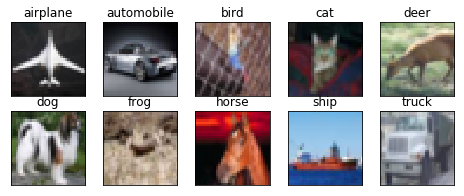

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
#Convert the images in training dataset and test set into multidimentional arrays of their pixel intensity values.

train_features = train_features.reshape(train_features.shape[0], 32, 32,3)
test_features = test_features.reshape(test_features.shape[0], 32, 32,3)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)
  
def space_to_depth_x4(x):
    return tf.space_to_depth(x, block_size=4)



#This method creates a max pool layer
def get_maxpool(input, blockname):
    c1 = Conv2D(64, (1, 1), strides=(1, 1), name=(blockname+'conv_1x1'), use_bias=False)(input)
    c1 = BatchNormalization(name=(blockname+'norm_1'))(c1)
    c1 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)
    c1 = MaxPooling2D(pool_size=(2, 2))(c1)
    c1 = Dropout(0.5)(c1)
    return c1

#This method creates and returns a Normal 3x3 convolution layer followed by batch normalization and ReLU activation
def get_conv_3x3_block(input, blockname):
    c1 = Conv2D(64, (3, 3), strides=(1, 1),padding='same', name=(blockname+'conv_1'), use_bias=False)(input)
    c1 = BatchNormalization(name=(blockname+'norm_1'))(c1)
    c1 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)
    c1 = Dropout(0.25)(c1)
    return c1
  
#This method creates and returns a Normal 5x5 convolution layer followed by batch normalization and ReLU activation
def get_conv_5x5_block(input, blockname):
    c1 = Conv2D(64, (5, 5), strides=(1, 1),padding='same', name=(blockname+'conv_1'), use_bias=False)(input)
    c1 = BatchNormalization(name=(blockname+'norm_1'))(c1)
    c1 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)
    c1 = Dropout(0.25)(c1)
    return c1

#This method creates and returns Depthwise separable convolution layer consisting of the following
# 5X5 convolution for each channel (depth_multiplier=1 ensures that the output consists of only one output channel for each input channel)
def get_sepconv_5x5_block(input, blockname):
    c1 = SeparableConv2D(64, (5, 5), strides=(1, 1), padding='same',depth_multiplier=1, name=(blockname+'conv_1'), use_bias=False)(input)
    c1 = BatchNormalization(name=(blockname+'norm_1'))(c1)
    c1 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)
    c1 = Dropout(0.25)(c1)
    return c1

#This method creates and returns Depthwise separable convolution layer consisting of the following
# 5X5 convolution for each channel (depth_multiplier=1 ensures that the output consists of only one output channel for each input channel)
def get_sepconv_3x3_block(input, blockname):
    c1 = SeparableConv2D(64, (3, 3), strides=(1, 1), padding='same',depth_multiplier=1, name=(blockname+'conv_1'), use_bias=False)(input)
    c1 = BatchNormalization(name=(blockname+'norm_1'))(c1)
    c1 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)
    c1 = Dropout(0.25)(c1)
    return c1


#This method creates and returns a model

def create_model(input_shape,nb_classes=10):
    input = Input(shape=input_shape)

    L1_sep5 = get_sepconv_5x5_block(input,'b1_')
    
    L2_con5 = get_conv_5x5_block(L1_sep5,'b2_')
    
    L3_con5 = get_conv_5x5_block(L2_con5,'b3_')
    
    concat_1 = Concatenate(axis=-1)([L1_sep5,L3_con5])
    concat_1 = Conv2D(64, (1, 1), strides=(1, 1), name='concat_1_1x1', use_bias=False)(concat_1)
    
    L4_sep5 = get_sepconv_5x5_block(concat_1,'b4_')
    
    concat_2 = Concatenate(axis=-1)([L1_sep5,L4_sep5])
    
    L5_maxp = get_maxpool(concat_2,'m1_')
    
    L6_sep3 = get_sepconv_3x3_block(L5_maxp,'b5_')
    
    L1_sep5 = Lambda(space_to_depth_x2)(L1_sep5)
    L4_sep5 = Lambda(space_to_depth_x2)(L4_sep5)

    
    concat_3 = Concatenate(axis=-1)([L1_sep5,L4_sep5,L6_sep3])
    concat_3 = Conv2D(64, (1, 1), strides=(1, 1), name='concat_3_1x1', use_bias=False)(concat_3)
    
    L7_con5 = get_conv_5x5_block(concat_3,'b6_')
    
    L3_con5 = Lambda(space_to_depth_x2)(L3_con5)
    
    
    concat_4 = Concatenate(axis=-1)([L3_con5,L4_sep5,L6_sep3,L7_con5])
    concat_4 = Conv2D(64, (1, 1), strides=(1, 1), name='concat_4_1x1', use_bias=False)(concat_4)
    
    L8_sep3 = get_sepconv_3x3_block(concat_4,'b7_')
    
    concat_5 = Concatenate(axis=-1)([L3_con5,L4_sep5,L6_sep3,L7_con5,L8_sep3])
    concat_5 = Conv2D(64, (1, 1), strides=(1, 1), name='concat_5_1x1', use_bias=False)(concat_5)
    
    L9_sep5 = get_sepconv_5x5_block(concat_5,'b8_')
    
    concat_6 = Concatenate(axis=-1)([L1_sep5,L4_sep5,L6_sep3,L8_sep3,L9_sep5])
    
    
    L10_maxp = get_maxpool(concat_6,'m2_')
    
    L7_con5 = Lambda(space_to_depth_x2)(L7_con5)
    
    concat_7 = Concatenate(axis=-1)([L7_con5,L10_maxp])
    concat_7 = Conv2D(64, (1, 1), strides=(1, 1), name='concat_7_1x1', use_bias=False)(concat_7)
    
    L11_con5 = get_conv_5x5_block(concat_7,'b9_')
    
    
    L2_con5 = Lambda(space_to_depth_x4)(L2_con5)
    L4_sep5 = Lambda(space_to_depth_x2)(L4_sep5)
    L8_sep3 = Lambda(space_to_depth_x2)(L8_sep3)
    
    
    concat_8 = Concatenate(axis=-1)([L2_con5,L4_sep5,L8_sep3,L11_con5])
    concat_8 = Conv2D(64, (1, 1), strides=(1, 1), name='concat_8_1x1', use_bias=False)(concat_8)
    
    L12_sep5 = get_sepconv_5x5_block(concat_8,'b10_')
    

    L3_con5 = Lambda(space_to_depth_x2)(L3_con5)
    L6_sep3 = Lambda(space_to_depth_x2)(L6_sep3)
    
    
    concat_9 = Concatenate(axis=-1)([L2_con5,L3_con5,L6_sep3,L11_con5,L12_sep5])
    concat_9 = Conv2D(64, (1, 1), strides=(1, 1), name='concat_9_1x1', use_bias=False)(concat_9)
    
    L13_con3 = get_conv_3x3_block(concat_9,'b11_')
    
    L1_sep5 = Lambda(space_to_depth_x2)(L1_sep5)
    
    concat_10 = Concatenate(axis=-1)([L1_sep5,L3_con5,L4_sep5,L6_sep3,L8_sep3,L12_sep5,L13_con3])
    concat_10 = Conv2D(64, (1, 1), strides=(1, 1), name='concat_10_1x1', use_bias=False)(concat_10)
    
    L14_sep5 = get_sepconv_5x5_block(concat_10,'b12_')
    
    concat_11 = Concatenate(axis=-1)([L4_sep5,L8_sep3,L12_sep5,L14_sep5])
    
    conv_1x1 = Conv2D(nb_classes, (1, 1), strides=(1, 1), name='conv1', use_bias=False)(concat_11)
    
    lastconvolution = Conv2D(nb_classes, (8, 8), strides=(1, 1), name='conv2', use_bias=False)(conv_1x1)
    
    flattenedoutput = Flatten()(lastconvolution)
    output = Activation('softmax')(flattenedoutput)
    model = Model(inputs=[input], outputs=[output])
    return model    
    


In [0]:
model = create_model((img_rows,img_cols,img_channels), num_classes)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [54]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
b1_conv_1 (SeparableConv2D)     (None, 32, 32, 64)   267         input_10[0][0]                   
__________________________________________________________________________________________________
b1_norm_1 (BatchNormalization)  (None, 32, 32, 64)   256         b1_conv_1[0][0]                  
__________________________________________________________________________________________________
re_lu_115 (ReLU)                (None, 32, 32, 64)   0           b1_norm_1[0][0]                  
__________________________________________________________________________________________________
dropout_39

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
390/390 [==============================] - 71s 181ms/step - loss: 1.6036 - acc: 0.4291 - val_loss: 1.3321 - val_acc: 0.5258
Epoch 2/100
390/390 [==============================] - 61s 157ms/step - loss: 1.1665 - acc: 0.5843 - val_loss: 1.3936 - val_acc: 0.5302
Epoch 3/100
390/390 [==============================] - 61s 157ms/step - loss: 0.9617 - acc: 0.6643 - val_loss: 0.8871 - val_acc: 0.6974
Epoch 4/100
390/390 [==============================] - 61s 157ms/step - loss: 0.8328 - acc: 0.7094 - val_loss: 0.9727 - val_acc: 0.6699
Epoch 5/100
390/390 [==============================] - 62s 158ms/step - loss: 0.7449 - acc: 0.7372 - val_loss: 0.7848 - val_acc: 0.7327
Epoch 6/100
390/390 [==============================] - 61s 157ms/step - loss: 0.6829 - acc: 0.7604 - val_loss: 0.7626 - val_acc: 0.7405
Epoch 7/100
390/390 [==============================] - 61s 157ms/step - loss: 0.6206 - acc: 0.7813 - val_loss: 0.7606 - val_acc: 0.7447
Epoch 8/100
390/390 [===========================

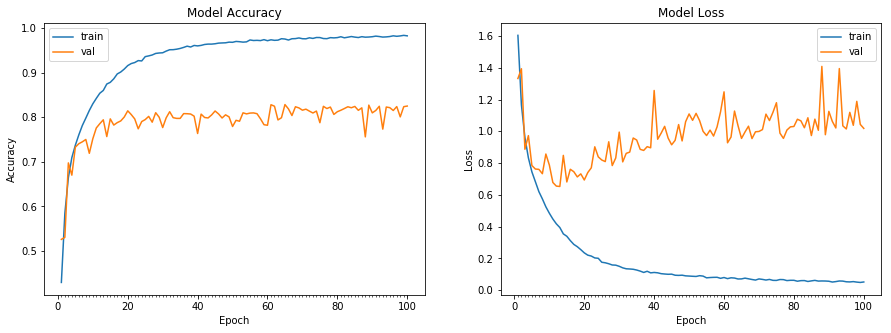

Accuracy on test data is: 82.50


In [55]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model #128
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))